# Crash Course on JAX - 20/12/2022

T. Teijeiro - *tteijeiro@bcamath.org*

## 1. JAX: What and why?
[JAX](https://jax.readthedocs.io) is a **Python library for gradient-based Machine Learning research** developed by Google. Its main difference with respect to Tensorflow or Pytorch is that it allows in a straightforward way a very fine-grained control of model definition, training, and debugging. Also, it is extremely fast, and automatically manages parallelization and load distribution among CPUs, GPUs and TPUs. Finally, JAX is designed from a [functional programming](https://en.wikipedia.org/wiki/Functional_programming) perspective, and this paradigm is encouraged to get the most of the library. This makes JAX implementations much closer to their mathematical definition than on other frameworks.

JAX is especially convenient on the early stages of model development, since it allows you to perform experiments very quickly and with a full control of every element in the pipeline (data partitioning, loss functions, gradients, optimization...). These basic models can then be easily scaled to state-of-the-art sizes in terms of number of parameters, dataset volume, etc.

## 2. JAX: The fundamentals

From an API point of view, JAX is basically equivalent to `numpy`. All functions in `jax.numpy` have the same signature and behavior as their counterpart in `numpy`, but they are adapted to support the three basic features of the JAX framework:

 1. Automatic differentiation.
 2. Just-in-Time compilation.
 3. Automatic vectorization.
 
Below we show how to use each of these features, their practical limitations, and how advanced optimization is built on top of them. 
 

### 2.0 Installation and set-up

As expected, [installing JAX](https://github.com/google/jax#installation) is pretty straightforward using `pip` or `conda`, but currently only Linux and Mac OS are properly supported (on Windows, you have to either use the [Windows Subsystem for Linux](https://learn.microsoft.com/en-us/windows/wsl/about), restrict the installation to the [CPU version](https://github.com/cloudhan/jax-windows-builder), or build it from sources).

The most convenient way is probably using `conda`, which just requires the following command:

```bash
$ conda install -c conda-forge jax
```

Then, the following two imports are the standard way to get access to the full JAX functionality:

In [1]:
#JAX imports
import jax
import jax.numpy as jnp

#Additional regular imports
import numpy as np
import matplotlib.pyplot as plt

### 2.1 Working with automatic differentiation

Jax is the continuation of the [Autograd](https://github.com/hips/autograd) library, and can automatically differentiate almost any Python and NumPy code you may have. It supports conditionals, loops, recursion and closures, and can calculate higher-order derivatives. Both [reverse-mode and forward-mode](https://alexey.radul.name/ideas/2013/introduction-to-automatic-differentiation/) differentiation are supported.

The basic functions for automatic differentiation are `jax.grad()` and `jax.value_and_grad()`. Both receive a function and return another function, depending if you are interested in only evaluating the gradient, or both the gradient and the original function.

Let's start with a basic example:

In [2]:
def f(x, y):
    return x+y**2

df = jax.grad(f)

print(f"Gradient of f at (2,2): {df(2., 2.)}")

Gradient of f at (2,2): 1.0


🤔 The result is a bit surprising, since the function `f` has two input variables, and thus we would expect a 2-value gradient vector. The reason is that, by default, `grad()` only evaluates the gradient with respect to the first argument. If we want to differentiate with respect to more arguments (or just different ones), we need to modify the `argnums` parameter:

In [3]:
dfy = jax.grad(f, 1)
dfxy = jax.grad(f, (0, 1))

print(f"Gradient of f with respect to y at (2,2): {dfy(2., 2.)}")
print(f"Gradient of f with respect to x and y at (2,2): {np.array(dfxy(2., 2.))}")

Gradient of f with respect to y at (2,2): 4.0
Gradient of f with respect to x and y at (2,2): [1. 4.]


`jax.grad()` is flexible enough to support very complex and entangled Python constructs:

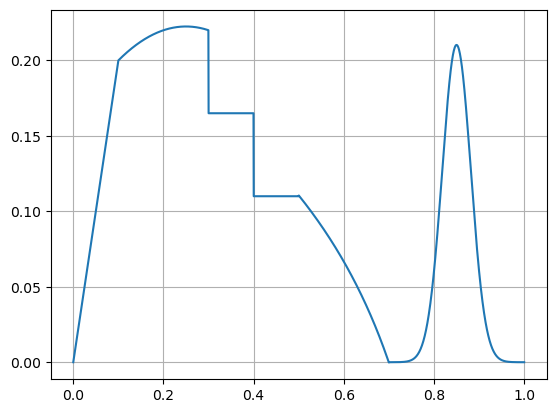

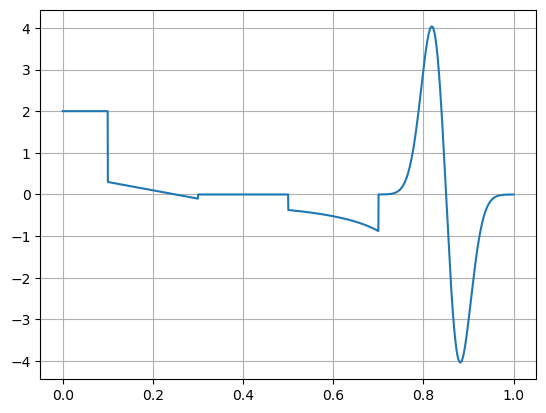

In [4]:
def f_tangled(x):
    if 0 <= x <= 1:
        if x < 0.1:
            return 2*x
        if x < 0.3:
            return 0.2225-(x-0.25)**2
        for i in range(2):
            if (x-0.3)//0.1 == i:
                return 0.165 if i==0 else f_tangled(x-0.1)-0.055
        if x < 0.7:
            x = 0.5+(x-0.5)*1.4412477
            return 0.2+jnp.log(1-x)/7.75
        return jax.scipy.stats.multivariate_normal.pdf(x, 0.85, 0.001)/60
    return 0

X = np.linspace(0, 1, 2000)
plt.plot(X, [f_tangled(x) for x in X])
plt.grid()
plt.figure()
df_tangled = jax.grad(f_tangled)
plt.plot(X, [df_tangled(x) for x in X])
plt.grid()

By convention, in JAX the functions to be differentiated (typically loss functions) declare a **first argument which groups all the parameters involved in gradient calculation**, and for the rest of the arguments the gradients are not calculated (e.g., the true labels of a mini-batch). This first argument is usually a `jax.numpy` array or a dictionary of named arrays. We illustrate this below in the [section about optimization](http://localhost:8888/notebooks/Crash%20course%20on%20JAX%20-%20BCAM%2015-12-2022.ipynb#4.-Gradient-based-optimization:-Optax).

### 2.2 Just-in-Time Compilation

The second pillar that makes JAX such a convenient tool for ML model development is the just-in-time compilation of code for multiple devices (CPU, GPU, TPU). The main entry point to this functionality is `jax.jit()`, that can be used both as a function or as a decorator `@jax.jit`. Let's run a basic example with a function that computes the Euclidean pairwise distances on an N-dimensional dataset with M samples:

In [5]:
def pairwise_distances(X):
    M = X.shape[0]
    N = X.shape[1]
    D = jnp.empty((M, M))
    for i in range(M):
        for j in range(M):
            d = 0.0
            for k in range(N):
                tmp = X[i, k] - X[j, k]
                d += tmp * tmp
            D = D.at[i, j].set(jnp.sqrt(d))
    return D

pw_distances_compiled = jax.jit(pairwise_distances)

#Basic check to ensure that the result is the same in both functions
X = np.array([[0, 1], [1, 0], [2, 0]])
np.allclose(pairwise_distances(X), pw_distances_compiled(X), atol=1e-6)

True

We check how faster the compiled version can be:

In [6]:
%timeit pairwise_distances(X)
%timeit pw_distances_compiled(X)

4.44 ms ± 9.44 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.54 µs ± 53.7 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


However, this amazing speedup does not come for free. While being as easy to use as `jax.grad()`, `jax.jit()`, we need to be aware of several constraints in order to optimize our code as much as possible. The following table summarizes which Python constructs we can use safely in our functions, and which ones we should be careful about:

\begin{split}
\begin{array} {r|rr} 
\hline \
\textrm{construct} 
& \textrm{jit} 
& \textrm{grad} \\
\hline \
\textrm{if} & ❌ & ✔ \\
\textrm{for} & ✔* & ✔\\
\textrm{while} & ✔* & ✔\\
\textrm{lax.cond} & ✔ & ✔\\
\textrm{lax.while_loop} & ✔ & \textrm{fwd}\\
\textrm{lax.fori_loop} & ✔ & \textrm{fwd}\\
\textrm{lax.scan} & ✔ & ✔\\
\hline
\end{array}
\end{split}
$\ast=$ argument-**value**-independent loop condition - unrolls the loop

We can see that classical control flow constructs (**if**, **for** and **while**) can be troublesome for `jit` compilation, and that is why JAX provides some functional alternatives in the `jax.lax` package. As a functional framework, the rule of thumb would when programming in JAX would be:

 - *Avoid any control flow in your code, and just write it as a sequence of calls to `jax.*` functions.*
 
#### Exercise 2.2.1:

Rewrite the `pairwise_distances` function to avoid Python control flow structures by using JAX operations, and characterize its performance with and without `jit` compared to the Numpy equivalent implementation.

##### Hint:
 - Numpy's [Broadcasting](http://scipy-lectures.org/intro/numpy/operations.html#broadcasting) (also supported in JAX) allows us to perform combinatory operations on arrays through shape manipulation.

##### Solution to 2.2.1:

In [ ]:
@jax.jit
def pw_distances_jax(Y):
    #Broadcasting allows us to calculate all pairwise differences
    return ??

### 2.3 Auto-Vectorization

Last, but not least, JAX provides the [`jax.vmap`](https://jax.readthedocs.io/en/latest/_autosummary/jax.vmap.html) transformation, which performs automatic vectorization of functions. This means is that it allows you to compute the output of a function **in parallel over some axis of the input**, making it extremely convenient for use cases such as the following ones:
 - You can develop your functions assuming a scalar input, and this functions will automatically work with multidimensional inputs.
 - A loss function that is calculated for a single example can be directly transformed to work with *minibatches*.
 
This functionality is similar to that provided by `numpy.vectorize`, but the [semantics are different](https://stackoverflow.com/questions/69099847/jax-vectorization-vmap-and-or-numpy-vectorize), and it is [more efficient](https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.vectorize.html).

As a basic example, let's assume we have a trained logistic regression model with fixed coefficients and intercept, and we define the following function to estimate the probability of a new sample:

In [7]:
def predict_proba(sample):
    coefs = jnp.array([-0.44501376,  0.89999242, -2.32353827, -0.97345836])
    intercept = 6.69040651
    score = jnp.dot(coefs, sample) + intercept
    return jax.nn.softmax(jnp.array([-score, score]))[0]

#Array of samples
X = np.array([[5.2, 4.1, 1.5, 0.1],
              [5.7, 3.8, 1.7, 0.3],
              [5.5, 2.6, 4.4, 1.2],
              [6.3, 2.7, 4.9, 1.8],
              [5.9, 3. , 4.2, 1.5],
              [5. , 2.3, 3.3, 1. ],
              [5.7, 2.6, 3.5, 1. ],
              [6.2, 3.4, 5.4, 2.3]])

#We can predict the probability of a single sample
print(f'Probability of the first sample: {predict_proba(X[0]):.8f}')

Probability of the first sample: 0.00012750


But if we try to apply the function to the full set of samples...

In [8]:
print(predict_proba(X))

TypeError: Incompatible shapes for dot: got (4,) and (8, 4).

So we vectorize the function with `vmap()` to support this. We also compare the performance gain with respect to using a Python loop, and the additional benefits that `jit()` can provide.

In [9]:
vpredict_proba = jax.vmap(predict_proba)
print(vpredict_proba(X))
%timeit [predict_proba(sample) for sample in X]
%timeit vpredict_proba(X)
#The function can be also jitted for further efficiency
vpredict_proba_compiled = jax.jit(vpredict_proba)
%timeit vpredict_proba_compiled(X)

[1.2749569e-04 1.2750516e-03 9.9993348e-01 9.9999881e-01 9.9986482e-01
 9.8539424e-01 9.9464345e-01 9.9999988e-01]
3.04 ms ± 37.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.18 ms ± 42.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.63 µs ± 76 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


The use of `vmap` is trivial when we only want to vectorize with respect to a single axis, but it may become complex if the vectorized function works with several multi-dimensional arguments. In this cases, it is not unusual to rely on the composition of multiple `vmap`. In these cases, a proper definition of the `in_axes` parameter is fundamental.

As an example, let's implement the functionality provided by the `pairwise_distance()` function above using as basis the function to calculate the distance between two points, and then using `vmap` to vectorize it over the two dimensions.

In [10]:
def dist(x, y):
    return jnp.linalg.norm(x-y)

X = np.array([[0, 1], [1, 0], [2, 0]])

print(f'Distance between points 0 and 1: {dist(X[0], X[1])}')

#With vmap, we can calculate the distance from one point to all the others (the first argument is not vectorized)
y_vmap_dist = jax.vmap(dist, in_axes=(None, 0))
print(f'Distance between point 0 and all others: {y_vmap_dist(X[0], X)}')

#With a second vmap, we can vectorize with respect to the first argument as well, achieving all-pairs functionality
xy_vmap_dist = jax.vmap(y_vmap_dist, in_axes=(0, None))
print(f'Distance between all pairs: \n{xy_vmap_dist(X, X)}')

#Finally, we jit the function and set the interface to be the same as for previous implementations.
j_vmap_dist = jax.jit(lambda X:xy_vmap_dist(X, X))
%timeit j_vmap_dist(X)

Distance between points 0 and 1: 1.4142135381698608
Distance between point 0 and all others: [0.        1.4142135 2.236068 ]
Distance between all pairs: 
[[0.        1.4142135 2.236068 ]
 [1.4142135 0.        1.       ]
 [2.236068  1.        0.       ]]
2.36 µs ± 64.5 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


### Final Exercise 2: 

Considering the following code, which generates an image of the Mandelbrot set using a grid of complex numbers.
 1. Introduce the required changes to make it `jit`-compilable.
 2. Rewrite it so it runs as efficiently as possible, using `vmap`.
 3. Characterize the speedup you can get with respect to the original function.

In [ ]:
def mandelbrot(z, max_iters):
    c = z
    for n in range(max_iters):
        if abs(z) > 2:
            return n
        z = z * z + c
    return max_iters


def mandelbrot_set(xmin, xmax, ymin, ymax, width, height, max_iters):
    r1 = np.linspace(xmin, xmax, width)
    r2 = np.linspace(ymin, ymax, height)
    n3 = np.empty((width,height))
    for i in range(width):
        for j in range(height):
            n3[i,j] = mandelbrot(r1[i] + 1j*r2[j], max_iters)
    return n3

%timeit mandelbrot_set(-2, 0.5, -1.25, 1.25, 1000, 1000, 100)
mandel = mandelbrot_set(-2, 0.5, -1.25, 1.25, 1000, 1000, 100)
plt.imshow(mandel.T)

##### Solution to Final Exercise 2:

In [ ]:
def mandelbrot_set(xmin, xmax, ymin, ymax, width, height, max_iters):
    ??

In [ ]:
%timeit mandelbrot_set(-2, 0.5, -1.25, 1.25, 1000, 1000, 100)
mandel = mandelbrot_set(-2, 0.5, -1.25, 1.25, 1000, 1000, 100)
plt.imshow(mandel.T)

## 3. Gradient-based optimization: Optax

While the basic functionality of JAX is fundamentally limited to autograd+acceleration, there is a very active and growing ecosystem that provides all the core components required to **optimize parametric models**. In particular, the first library we will probably require in practical problems is [Optax](https://optax.readthedocs.io/en/latest/index.html): the gradient processing and optimization library for JAX.

### 3.1 Getting started with Optax

To start working with Optax, we basically require two elements:
 - An objective function to be optimized. This is typically a **loss function** calculated on the model parameters that will be minimized through gradient descent, and therefore has to be differentiable.
 - An optimizer, which is the component in charge of processing the gradients and **calculate a new value for the target parameters**. This optimizer is usually executed in an iterative fashion.
 
Optax provides a comprehensive catalog of both [losses](https://optax.readthedocs.io/en/latest/api.html#common-losses) and [optimizers](https://optax.readthedocs.io/en/latest/api.html#common-optimizers), which can be recombined and composed with our own functions, making it possible to combine low level ingredients into custom optimisers (or other gradient processing components).

Let's take a look to the typical Optax pipeline by implementing [Logistic Regression](https://en.wikipedia.org/wiki/Logistic_regression) in a toy dataset:

In [11]:
import optax
#Toy dataset and utilities
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

@jax.jit
def loss(params, X, y):
    """Loss function (binary cross-entropy)."""
    logits = jnp.log(jax.nn.sigmoid(jnp.dot(X, params['coef']) + params['intercept']))
    return optax.sigmoid_binary_cross_entropy(logits, y).mean()


def fit(params, optimizer, Xtrain, ytrain, epochs=1000):
    """Training function"""
    opt_state = optimizer.init(params)
    
    loss_value_grad = jax.value_and_grad(loss)
    
    @jax.jit
    def step(params, opt_state):
        """
        Each iteration in the training loop:
         1. Gradient calculation.
         2. Parameter changes calculation from gradients.
         3. Parameter updates (Gradient descent).
        """
        loss_value, grads = loss_value_grad(params, Xtrain, ytrain)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_value
    
    #Training loop
    for i in range(epochs):
        params, opt_state, loss_value = step(params, opt_state)
        if i % 100 == 0:
            print(f'Iteration {i:03d} loss: {loss_value:.3f}')
        
    return params, loss_value


X, y = load_iris(return_X_y=True)
#For simplicity, we'll train a binary model for the first class
y = (y==0).astype(np.int8)
#Random partition of training and testing
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2)

#Definition of the model parameters and the initial value.
initial_params = {
    'coef':jnp.full(X.shape[1], 1e-5),
    'intercept':1.0
}

optimizer = optax.adam(learning_rate=1e-3)

final_params, loss_value = fit(initial_params, optimizer, Xtrain, ytrain)
print(final_params)
print(f'Final loss: {loss_value:.3f}')

#Classification performance on the testing set:
probs = jax.nn.sigmoid(jnp.dot(Xtest, final_params['coef']) + final_params['intercept'])
print("Confusion matrix for the testing set:")
print(confusion_matrix(ytest, probs>0.5))

Iteration 000 loss: 0.648
Iteration 100 loss: 0.556
Iteration 200 loss: 0.495
Iteration 300 loss: 0.449
Iteration 400 loss: 0.413
Iteration 500 loss: 0.385
Iteration 600 loss: 0.363
Iteration 700 loss: 0.345
Iteration 800 loss: 0.330
Iteration 900 loss: 0.318
{'coef': DeviceArray([-0.31164718,  0.7635136 , -0.69554275, -0.7169453 ], dtype=float32), 'intercept': DeviceArray(1.3697925, dtype=float32)}
Final loss: 0.307
Confusion matrix for the testing set:
[[18  0]
 [ 0 12]]


### 3.2 Customized optimizers

One of the strong points of the JAX ecosystem is that every component is easily customizable, while at the same time you can exploit the provided and well-tested basic building blocks. An interesting option is the combination of different optimizers, that can be performed via **chaining** or **multi transform**.

For example, let's consider we want to apply a different optimizer to each parameter (e.g. Adam to the coefficients and SGD to the intercept). This is easily done as follows:

In [12]:
optimizer = optax.multi_transform({'adam':optax.adam(learning_rate=1e-3), 
                                   'sgd':optax.sgd(learning_rate=1e-2)},
                                  {'coef':'adam', 'intercept':'sgd'})

final_params, loss_value = fit(initial_params, optimizer, Xtrain, ytrain)
print(final_params)
print(f'Final loss: {loss_value:.3f}')

Iteration 000 loss: 0.648
Iteration 100 loss: 0.556
Iteration 200 loss: 0.495
Iteration 300 loss: 0.449
Iteration 400 loss: 0.414
Iteration 500 loss: 0.387
Iteration 600 loss: 0.365
Iteration 700 loss: 0.347
Iteration 800 loss: 0.332
Iteration 900 loss: 0.320
{'coef': DeviceArray([-0.2652976 ,  0.77780443, -0.69187135, -0.7166421 ], dtype=float32), 'intercept': DeviceArray(1.0442046, dtype=float32)}
Final loss: 0.309


Another way to combine optimizers is to apply several of them in sequence by means of `optax.chain()`. This is very useful to **define constraints** on the values of the parameters or the updates. For example, we can restrict the variation of each parameter on each iteration by chaining an `optax.clip()` operation after our regular Adam optimizer:

In [13]:
#We restrict the variation by excess, to appreciate the effect
optimizer = optax.chain(optax.adam(learning_rate=1e-3), optax.clip(0.0001))

final_params, loss_value = fit(initial_params, optimizer, Xtrain, ytrain)
print(final_params)
print(f'Final loss: {loss_value:.3f}')

Iteration 000 loss: 0.648
Iteration 100 loss: 0.640
Iteration 200 loss: 0.632
Iteration 300 loss: 0.623
Iteration 400 loss: 0.613
Iteration 500 loss: 0.603
Iteration 600 loss: 0.594
Iteration 700 loss: 0.584
Iteration 800 loss: 0.575
Iteration 900 loss: 0.567
{'coef': DeviceArray([-0.09999112, -0.06096965, -0.09999112, -0.09999112], dtype=float32), 'intercept': DeviceArray(0.8999834, dtype=float32)}
Final loss: 0.559


Of course, we can write arbitrary functions to be used in each of these stages, to replace or to be combined with any of the provided [optimizers](https://optax.readthedocs.io/en/latest/api.html#common-optimizers). The simplest way is to define a function that receives the parameters and the updates, and return new updates that can be arbitrarily modified.

For example, let us assume that in our problem, we want to force the coefficients to sum 1. This could be implemented as follows:

In [14]:
def scale_coefs_to_one(updates, params):
    """
    Function to scale the set of parameters to ensure that the sum is one.
    """
    no_scaled = params + updates
    scaled = jax.lax.cond(jnp.any(no_scaled), lambda v:v/jnp.sum(v), 
                          lambda v:jnp.ones_like(v)*1./len(v), no_scaled)
    #Remember, the output is the *updates*, not the parameter values.
    return scaled-params

#This is required to create a GradientTransformation from a function.
scale_transformation = optax.stateless_with_tree_map(scale_coefs_to_one)

optimizer = optax.chain(optax.adam(learning_rate=1e-3),
                        optax.masked(scale_transformation,
                                     {'coef':True, 'intercept':False}))

final_params, loss_value = fit(initial_params, optimizer, Xtrain, ytrain)
print(final_params)
print(f'Final loss: {loss_value:.3f}')  
print(f"Coefficient Sum: {jnp.sum(final_params['coef'])}")

Iteration 000 loss: 0.648
Iteration 100 loss: 0.694
Iteration 200 loss: 0.694
Iteration 300 loss: 0.693
Iteration 400 loss: 0.693
Iteration 500 loss: 0.692
Iteration 600 loss: 0.691
Iteration 700 loss: 0.690
Iteration 800 loss: 0.683
Iteration 900 loss: 0.484
{'coef': DeviceArray([-0.8004712, 14.533363 , -6.2586803, -6.474212 ], dtype=float32), 'intercept': DeviceArray(-0.00676165, dtype=float32)}
Final loss: 0.376
Coefficient Sum: 0.9999990463256836


## 4. Neural Networks with JAX: Flax and Linen

Moving to more complex models (and in particular Neural Networks) can be cumbersome and require a lot of boilerplate code to adapt them to the JAX+Optax functional framework. To help with this, the [Flax](https://flax.readthedocs.io/en/latest/index.html) library (and its evolution called Linen) provides a lot of functionality to define, train and validate Neural Network models. While JAX can be seen just as an efficient autograd library, and Optax as a bunch of predefined optimizers and loss functions, Flax would be at the level of TensorFlow or Pytorch in terms of aims and functionality.

For this reason, working with Flax requires getting familiar with a bunch of concepts and components that may not be trivial to understand, and which demand some effort and practice. A good starting point is this interesting description of the [Flax/Linen design principles](https://docs.google.com/document/d/1ZlL_4bXCw5Xl0WstQw1GpnZqfb9JFOeUGAPcBVk-kn8).

### 4.1 Getting started with Flax/Linen

From a practical perspective, the main **entry point to the Flax/Linen API is the [`flax.linen.Module`](https://flax.readthedocs.io/en/latest/api_reference/flax.linen.html#module) class**. This class allows us to define the architecture of our neural network, and to encapsulate all the code related to model evaluation and optimization. 

As an example, let's build a Multi-Layer Perceptron to learn the [2-D Ackley function](https://www.sfu.ca/~ssurjano/ackley.html) and to assess the accuracy difference of the model between interpolation and extrapolation. This is the definition of the function and how it looks like:

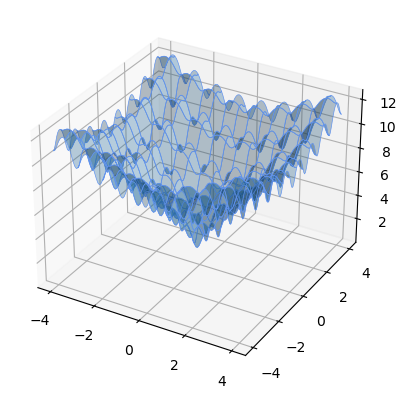

In [15]:
def ackley(p):
    """
    Evaluates the Ackley function for default values of a=20, b=0.2, c=2*pi
    Ref: https://www.sfu.ca/~ssurjano/ackley.html
    """
    n = len(p)
    s1 = jnp.sum(jnp.power(p, 2))
    s2 = jnp.sum(jnp.cos(2.*jnp.pi * p))
    return -20. * jnp.exp(-0.2 * jnp.sqrt(s1 / n)) - jnp.exp(s2 / n) + 20. + jnp.exp(1)

#Input space: Grid of 120x120 flattened to an array of points.
x, y = np.mgrid[-4:4:120j, -4:4:120j]
points = np.vstack([x.ravel(), y.ravel()]).T

#Vmapped version of the ackley function.
ack_vmapped = jax.jit(jax.vmap(ackley))
zz = ack_vmapped(points)

#3D plotting
ax = plt.figure().add_subplot(projection='3d')
ax.plot_surface(x, y, zz.reshape(x.shape), edgecolor='cornflowerblue', lw=0.5, rstride=8, cstride=8, alpha=0.3)

Now we define our MLP model with a classical 5-layer architecture and reducing the size on each layer:

In [16]:
import flax
import flax.linen as nn

class MLP(nn.Module):
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(128)(x)
        x = nn.relu(x)
        x = nn.Dense(64)(x)
        x = nn.relu(x)
        x = nn.Dense(32)(x)
        x = nn.relu(x)
        x = nn.Dense(16)(x)
        x = nn.relu(x)
        x = nn.Dense(1)(x)
        return x

The notation seems simple and clear, but it gives the impression that under the hood it happens more than what it obvious, particularly due to the `@nn.compact` notation. This is just a helper to simplify the definition of variables using in-line notation. More details are given [in the documentation](https://flax.readthedocs.io/en/latest/guides/setup_or_nncompact.html).

Now, we can already instantiate our model, and more importantly, **initialize** it by means of the `init` method. Initialization consists of creating the model arrays of the proper shape, and giving initial values to each of them. Since initialization is usually done in a random fashion, and in JAX [random generators have to be passed explicitly](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#random-numbers) to where they are used, models are always **initialized by passing a random generator as the first argument**. Then, the sizes of all the arrays are inferred from an input sample that has to be passed as the second argument. This argument is only used to infer sizes, so the values can be arbitrary.

As a result, the `init` method will return a dictionary with all the relevant variables for the model. In our case, this only include the model parameters, which will be grouped in a single dictionary named `params`.

In [19]:
#Random states in JAX have to be managed explicitely
rng = jax.random.PRNGKey(42)

net = MLP()
params = net.init(rng, jnp.array([0, 0]))['params']

The next step is to create a **training state** that will collect all the information required at each step of training. Flax provides the class [`TrainState`](https://flax.readthedocs.io/en/latest/api_reference/flax.training.html#train-state) with all the required elements, also supporting an Optax optimizer and its state:

In [20]:
from flax.training.train_state import TrainState

tx = optax.adam(learning_rate=1e-3)
trainst = TrainState.create(apply_fn=net.apply, params=params, tx=tx)

Next, we define the training function that will be used for each epoch, and that will perform the following tasks:

 - Measure the approximation error and the gradients.
 - Run an optimization step.
 - Return the optimizer with updated parameters and the training loss.

In [21]:
@jax.jit
def train_epoch(state, xtrain, rng):
    
    @jax.jit
    def loss_fn(params):
        preds = net.apply({'params':params}, xtrain).squeeze()
        return jnp.sum(optax.l2_loss(preds, ack_vmapped(xtrain)))
    
    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss    

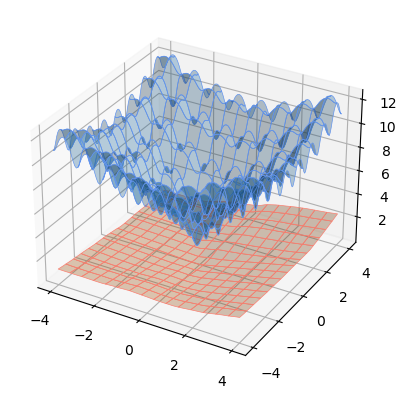

In [22]:
#Visualization of the output of the neural network before training
preds = net.apply({'params':trainst.params}, points).reshape(120, 120)
ax = plt.figure().add_subplot(projection='3d')
ax.plot_surface(x, y, zz.reshape(x.shape), edgecolor='cornflowerblue', lw=0.5, rstride=8, cstride=8, alpha=0.3)
ax.plot_surface(x, y, preds, edgecolor='salmon', lw=0.5, rstride=8, cstride=8, alpha=0.3)

Now we implement the training cycle as an iterative call to the training function, and we visualize the result after a predefined number of epochs.

Epoch 0, loss: 854.810303
Epoch 100, loss: 844.011353
Epoch 200, loss: 836.709229
Epoch 300, loss: 829.540955
Epoch 400, loss: 822.214966
Epoch 500, loss: 814.265015
Epoch 600, loss: 808.300171
Epoch 700, loss: 799.004211
Epoch 800, loss: 788.388428
Epoch 900, loss: 778.825256
Epoch 1000, loss: 770.802795
Extrapolation error: 0.269, Interpolation error: 0.150


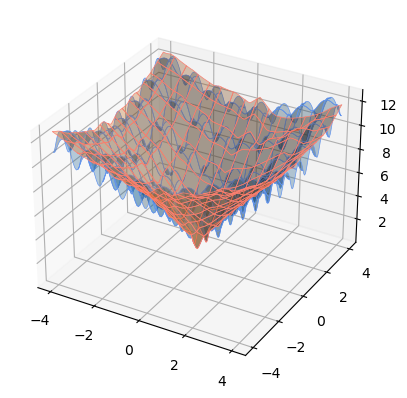

In [24]:
#For training, we select only those points < (3,3), and from those we pick just half of them randomly.
mask = jnp.logical_and(points[:,0]<=3, points[:,1]<=3)
mask2 = jnp.logical_and(np.random.rand(len(mask))>0.5, mask)

train_points = points[mask2, :]
test_extra = points[jnp.logical_not(mask), :]
test_inter = points[jnp.logical_and(jnp.logical_not(mask2), mask), :]

for epoch in range(1001):
    trainst, loss = train_epoch(trainst, train_points, rng)
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, loss: {loss:.6f}')
        
#Visualization of the output of the neural network before training
preds = net.apply({'params':trainst.params}, points).reshape(120, 120)
ax = plt.figure().add_subplot(projection='3d')
ax.plot_surface(x, y, zz.reshape(x.shape), edgecolor='cornflowerblue', lw=0.5, rstride=8, cstride=8, alpha=0.3)
ax.plot_surface(x, y, preds, edgecolor='salmon', lw=0.5, rstride=8, cstride=8, alpha=0.3)
#Calculation of extrapolation and interpolation errors:
preds_extra = net.apply({'params':trainst.params}, test_extra).squeeze()
extra_loss = jnp.mean(optax.l2_loss(preds_extra, ack_vmapped(test_extra)))
preds_inter = net.apply({'params':trainst.params}, test_inter).squeeze()
inter_loss = jnp.mean(optax.l2_loss(preds_inter, ack_vmapped(test_inter)))
print(f'Extrapolation error: {extra_loss:.3f}, Interpolation error: {inter_loss:.3f}')

### 4.2 Interactive visualization of the training cycle

The simplicity of the Flax framework makes it possible to embed the training cycle on any common Python program, and this opens a lot of possibilities to enrich the model development process. One particular example is regarding debugging and dynamic visualization, since we can easily plot the learning process for example using the [`matplotlib.animation`](https://matplotlib.org/stable/api/animation_api.html) API:

In [25]:
#We select the interactive backend to visualize the animation
%matplotlib qt
from matplotlib.animation import FuncAnimation

#Initialization of a new training state, and new figure showing the target and initial values.
trainst = TrainState.create(apply_fn=net.apply, params=params, tx=tx)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
surf_orig = ax.plot_surface(x, y, zz.reshape(x.shape), edgecolor='cornflowerblue', lw=0.5, rstride=8, cstride=8, alpha=0.3)
surf_learn = ax.plot_surface(x, y, preds, edgecolor='salmon', lw=0.5, rstride=8, cstride=8, alpha=0.3)

def update_animation(frame):
    """Animation function, that executes one training step and updates the plot"""
    global trainst, surf_learn
    preds = net.apply({'params':trainst.params}, points).reshape(120, 120)
    surf_learn.remove()
    surf_learn = ax.plot_surface(x, y, preds, edgecolor='salmon', lw=0.5, rstride=8, cstride=8, alpha=0.1)
    trainst, loss = train_epoch(trainst, points, rng)
    ax.set_title(f'Epoch: {frame}, Loss: {loss:.3f}')

anim = FuncAnimation(fig, update_animation, frames=1000, interval=20, repeat=False)

In [26]:
#If necessary to go back to inline plots
%matplotlib inline

## References 
 1. JAX General Documentation: https://jax.readthedocs.io/en/latest/index.html
 2. Optax General Documentation: https://optax.readthedocs.io/en/latest/index.html
 3. Flax General Documentation: https://flax.readthedocs.io/en/latest/index.html
 4. Introduction to Automatic Differentiation: https://alexey.radul.name/ideas/2013/introduction-to-automatic-differentiation/
 5. JAX Autodiff Cookbook: https://jax.readthedocs.io/en/latest/notebooks/autodiff_cookbook.html